In [1]:
from datetime import datetime,timedelta
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
from scipy.signal import savgol_filter
from bs4 import BeautifulSoup
import xml.etree.ElementTree as et
from datetime import timedelta

addressPrefix='C:/Users/sorush.omidvar/Google Drive/Documents/Educational/TAMU/Research/CGM Dataset/OhioT1/'
if not os.path.exists(addressPrefix):
    addressPrefix='C:/GDrive/Documents/Educational/TAMU/Research/CGM Dataset/OhioT1/'
pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use({'figure.facecolor':'white'})

In [2]:
def DataReader(fileAddress):
    xmlTree = et.parse(fileAddress)
    xmlRoot = xmlTree.getroot()
    patientId=xmlRoot.attrib
    patientId=patientId['id']
    data=[]
    for parameter in xmlRoot:
        parameterName=parameter.tag
        for element in parameter:
            temporary=element.attrib
            if 'ts_begin' in temporary:
                tStartTemp=temporary['ts_begin']
            elif 'ts' in temporary:
                tStartTemp=temporary['ts']
            elif 'tbegin' in temporary:
                tStartTemp=temporary['tbegin']
            tStart = datetime.strptime(tStartTemp, '%d-%m-%Y %H:%M:%S')

            if 'ts_ebd' in temporary:
                tEndTemp=temporary['ts_end']
                tEnd = datetime.strptime(tEndTemp, '%d-%m-%Y %H:%M:%S')
            elif 'tend' in temporary:
                tEndTemp=temporary['tend']
                tEnd = datetime.strptime(tEndTemp, '%d-%m-%Y %H:%M:%S')
            elif 'duration' in temporary:
                tEnd=tStart+timedelta(minutes=int(temporary["duration"]))
            else:
                tEnd=tStart

            if 'value' in temporary:
                val=float(temporary['value'])
            elif 'dose' in temporary:
                val=float(temporary['dose'])
            elif 'carbs' in temporary:
                val=float(temporary['carbs'])
            elif 'quality' in temporary:
                val=float(temporary['quality'])
            elif 'intensity' in temporary:
                val=float(temporary['intensity'])

            extra=''
            if 'bwz_carb_input' in temporary:
                extra=float(temporary['bwz_carb_input'])
            elif 'type' in temporary:
                extra=temporary['type']

            data.append([patientId,parameterName,tStart,tEnd,val,extra])
    df = pd.DataFrame(data, columns = ["Patient","Parameter", "Start","End","Value","Extra"])
    df.sort_values(by=['Parameter', 'Start'],inplace=True)
    return df

def dataResEnhancer(df):
    gapLength=1
    gapList=[]

    highResSensor=['basis_heart_rate','basis_gsr','basis_skin_temperature','glucose_level']
    for sensor in highResSensor:
        newQuery=df[df['Parameter']==sensor]
        for counter in range(0,len(newQuery)-1):
            if newQuery.iloc[counter+1,0]==newQuery.iloc[counter,0] and newQuery.iloc[counter+1,1]==newQuery.iloc[counter,1] and newQuery.iloc[counter+1,2]==newQuery.iloc[counter,2]:
                if newQuery.iloc[counter+1,3]-newQuery.iloc[counter,3]>gapLength:
                    gapList.append([newQuery.iloc[counter,0],newQuery.iloc[counter,1],newQuery.iloc[counter,2],
                                   newQuery.iloc[counter,3],newQuery.iloc[counter+1,3]])
    appendedData=[]
    for element in gapList:
        duration= element[4]-element[3]
        if duration%gapLength==0:
            fillerNumber=int(duration/gapLength-1)
        else:
            fillerNumber=int(duration/gapLength)
        for counter in range(0,fillerNumber):
            appendedData.append([element[0],element[1],element[2],element[3]+(counter+1)*gapLength,element[2],
                                    element[3]+(counter+1)*gapLength,float('nan'),''])

    df = df.append(pd.DataFrame(appendedData,columns=['Patient','Parameter','Start Day','Start Time','End Day','End Time','Value','Extra']),ignore_index = True)
    df.sort_values(by=['Patient','Parameter','Start Day','Start Time'],inplace=True)

    df=df.interpolate(method='linear')
    return df

def dataPreprocess(df):
    df.insert(2,"Start Day",float('nan'))
    df.insert(3,"Start Time",float('nan'))

    df.insert(5,"End Day",float('nan'))
    df.insert(6,"End Time",float('nan'))

    for counter in range(0,len(df)):
        df.iloc[counter,2]=df.iloc[counter,4].timetuple().tm_yday
        df.iloc[counter,3]=df.iloc[counter,4].hour*3600+df.iloc[counter,4].minute*60+df.iloc[counter,4].second

        df.iloc[counter,5]=df.iloc[counter,7].timetuple().tm_yday
        df.iloc[counter,6]=df.iloc[counter,7].hour*3600+df.iloc[counter,7].minute*60+df.iloc[counter,7].second

    del df['Start']
    del df['End']
    df=dataResEnhancer(df)

    return df

def loadingData(addressPrefix):
    addressTemp=os.path.join(addressPrefix,'AllDataaaaaa.csv')
    if os.path.exists(addressTemp):
        dfTotal = pd.read_csv(addressTemp)
    else:
        dfTotal = pd.DataFrame(columns = ["Patient","Parameter", "Start","End","Value","Extra"])
        os.chdir(addressPrefix)
        dataFiles=[]
        for root,dirs,files in os.walk(".", topdown=False):
           for file in files:
               if '.xml' in file:
                   temporary=os.path.normpath(os.path.join(addressPrefix,root,file))
                   dataFiles.append(temporary)
        for file in dataFiles:
            df=DataReader(file)
            print("completed:",file)
            dfTotal = pd.concat([dfTotal, df],axis=0)
            break


        dfTotal.sort_values(by=['Patient','Parameter','Start'],inplace=True)
        dfTotal=dataPreprocess(dfTotal)
        dfTotal.to_csv(os.path.join(addressPrefix,'AllData.csv'),index=False)
    return dfTotal

df=loadingData(addressPrefix)

completed: C:\Users\sorush.omidvar\Google Drive\Documents\Educational\TAMU\Research\CGM Dataset\OhioT1\2018\test\559-ws-testing.xml


['meal', 'basal', 'basis_heart_rate', 'work', 'basis_gsr', 'bolus', 'sleep', 'basis_sleep', 'basis_steps', 'basis_skin_temperature', 'basis_air_temperature', 'exercise', 'finger_stick', 'glucose_level']
      Patient Parameter  Start Day  Start Time  End Day  End Time  Value Extra
13552     559  exercise       18.0     60900.0     18.0   64320.0    5.0      


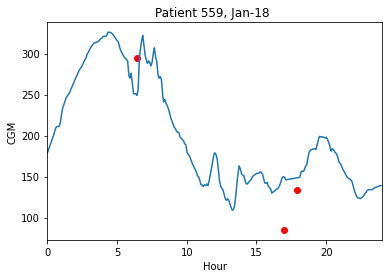

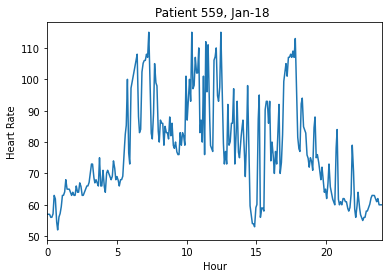

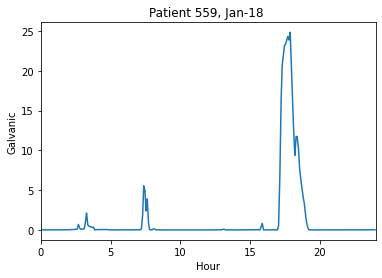

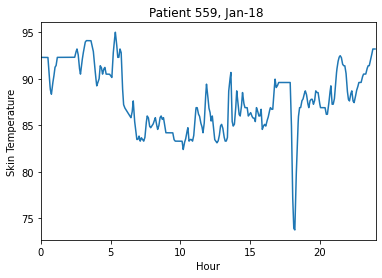

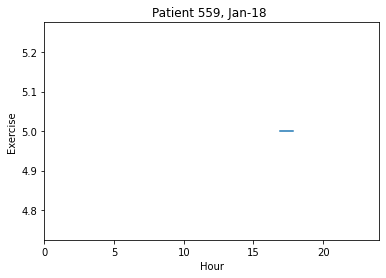

In [38]:
tempData=df[df['Patient']=='559']
tempData=tempData[tempData['Start Day']==18]
print(list(set(tempData['Parameter'].tolist())))

plt.figure
VarData=tempData[tempData['Parameter']=='glucose_level']
x=VarData['Start Time'].tolist()
x=np.asarray(x)/3600
plt.plot(x,VarData['Value'].tolist())

VarData2=tempData[tempData['Parameter']=='finger_stick']
x=VarData2['Start Time'].tolist()
x=np.asarray(x)/3600
plt.scatter(x,VarData2['Value'].tolist(),color='red')

plt.xlabel('Hour')
plt.ylabel('CGM')
plt.title('Patient 559, Jan-18 ')
plt.xlim(0,24)
plt.savefig(r'C:\GitHub\1.png')


plt.figure()
VarData=tempData[tempData['Parameter']=='basis_heart_rate']
x=VarData['Start Time'].tolist()
x=np.asarray(x)/3600
plt.plot(x,VarData['Value'].tolist())
plt.xlabel('Hour')
plt.ylabel('Heart Rate')
plt.title('Patient 559, Jan-18 ')
plt.xlim(0,24)
plt.savefig(r'C:\GitHub\2.png')

plt.figure()
VarData=tempData[tempData['Parameter']=='basis_gsr']
x=VarData['Start Time'].tolist()
x=np.asarray(x)/3600
plt.plot(x,VarData['Value'].tolist())
plt.xlabel('Hour')
plt.ylabel('Galvanic')
plt.title('Patient 559, Jan-18 ')
plt.xlim(0,24)
plt.savefig(r'C:\GitHub\3.png')

plt.figure()
VarData=tempData[tempData['Parameter']=='basis_skin_temperature']
x=VarData['Start Time'].tolist()
x=np.asarray(x)/3600
plt.plot(x,VarData['Value'].tolist())
plt.xlabel('Hour')
plt.ylabel('Skin Temperature')
plt.title('Patient 559, Jan-18 ')
plt.xlim(0,24)
plt.savefig(r'C:\GitHub\4.png')

plt.figure()
VarData=tempData[tempData['Parameter']=='exercise']
print(VarData)
x1=VarData['Start Time'].tolist()
x1=np.asarray(x1)/3600
x2=VarData['End Time'].tolist()
x2=np.asarray(x2)/3600

y1=VarData['Value'].tolist()
plt.plot([x1,x2],[y1,y1])
plt.xlabel('Hour')
plt.ylabel('Exercise')
plt.title('Patient 559, Jan-18 ')
plt.xlim(0,24)
plt.savefig(r'C:\GitHub\5.png')

In [28]:
a=df[df['Parameter']=='exercise']
print(a)

      Patient Parameter  Start Day  Start Time  End Day  End Time  Value Extra
13552     559  exercise       18.0     60900.0     18.0   64320.0    5.0      
13553     559  exercise       19.0     20700.0     19.0   23100.0    6.0      
13554     559  exercise       20.0     19680.0     20.0   23100.0    5.0      
13555     559  exercise       22.0     20400.0     22.0   26400.0    6.0      
13556     559  exercise       23.0     29700.0     23.0   32400.0    6.0      
13557     559  exercise       24.0     20400.0     24.0   23100.0    5.0      
13558     559  exercise       27.0     20220.0     27.0   23400.0    5.0      


In [ ]:
def dataCleaner(df):
    i = df[df.Date == 30].index #first data and noisy
    df=df.drop(i)

    i = df[df.Date == 40].index #Partial E4
    df=df.drop(i)

    i = df[df.Date == 41].index #No E4
    df=df.drop(i)

    i = df[df.Date >= 42].index #CGM becomes too noisy at the end of the study
    df=df.drop(i)

    return df

def dataAmputator(df):
    amputations=[[31,38290,39010],[31,61937,62638],[31,66226,71099],
              [32,58667,59563],[32,63875,63902],
              [33,25127,34731],[33,57996,58812],
              [34,25556,30763],[34,58736,59877],[34,66069,66092],
              [35,27945,31416],[35,57283,58147],
              [36,29865,33926],[36,59231,60096],
              [37,26911,32544],[37,40214,41380],
              [38,26707,34560],[38,38172,39273],
              [39,31053,35335],[39,57408,58655]]

    for amputation in amputations:
        i=df[(df['Date']==amputation[0]) & (df['Time']>=amputation[1]) & (df['Time']<=amputation[2])].index
        df.loc[i,'Value']=float('nan')
        # df=df.drop(i)

    return df

def loadingData(addressPrefix):
    if not os.path.exists(addressPrefix+'Result-interpolated.csv'):
        allDate=[]
        allTime=[]
        allVal=[]
        allPar=[]

        sensorList=[['intraday-ACC_E4.json','Acc'],['intraday-calories.json','Cal'],
                    ['intraday-EDA_E4.json','EDA'],['intraday-HR_E4.json','HR'],
                    ['intraday-steps.json','Step'],['intraday-TEMP_E4.json','Temp'],
                    ['intraday-glucose.json','CGM']]

        for element in sensorList:
            fileAddress=addressPrefix+element[0]
            allDate,allTime,allVal,allPar=loadingDataAux(fileAddress,element[1],allDate,allTime,allVal,allPar)

        dfOriginal = pd.DataFrame(list(zip(allDate,allTime,allVal,allPar)),
                          columns =['Date','Time','Value','Parameter'])
        dfOriginal=dfOriginal.sort_values(by=['Parameter','Date','Time'])
        dfOriginal.to_csv(addressPrefix+'Result-original.csv', header=True,index=False)
        print("Result-Original is saved")
        dfInterp=dataCleaner(dfOriginal)
        dfInterp=dataResEnhancer(dfInterp)
        dfInterp=dataAmputator(dfInterp)
        dfInterp.to_csv(addressPrefix+'Result-interpolated.csv', header=True,index=False)
        print("Result-Interpolated is saved")
    else:
        dfOriginal=pd.read_csv(addressPrefix+'Result-original.csv')
        dfInterp=pd.read_csv(addressPrefix+'Result-interpolated.csv')
    return dfOriginal,dfInterp

# dfOriginal,dfInterp=loadingData(addressPrefix)


Lag time= -2.0 Mean pearson= 0.129
[ 0.863  0.394  0.012 -0.796 -0.851 -0.292  0.383  0.943  0.502]
----------------------
Lag time= -1.5 Mean pearson= -0.315
[-0.374  0.103 -0.536 -0.328 -0.6   -0.411 -0.199 -0.38  -0.111]
----------------------
Lag time= -1.0 Mean pearson= -0.414
[-0.663 -0.74  -0.396 -0.326  0.133 -0.427 -0.615 -0.594 -0.1  ]
----------------------
Lag time= -0.5 Mean pearson= -0.155
[-0.29  -0.236 -0.462 -0.052  0.589 -0.353 -0.44  -0.017 -0.136]
----------------------
Lag time= 0.0 Mean pearson= 0.113
[-0.251  0.351  0.734  0.597 -0.48   0.034  0.789 -0.418 -0.342]
----------------------
Lag time= 0.5 Mean pearson= 0.174
[ 0.035  0.458  0.244  0.844 -0.62   0.664 -0.388 -0.097  0.426]
----------------------
Lag time= 1.0 Mean pearson= 0.125
[-0.549  0.469  0.243 -0.166 -0.123  0.306 -0.301  0.469  0.774]
----------------------
Lag time= 1.5 Mean pearson= -0.068
[-0.52  -0.355  0.648 -0.68  -0.365  0.353  0.706 -0.079 -0.321]
----------------------
Lag time= 2.0 Me

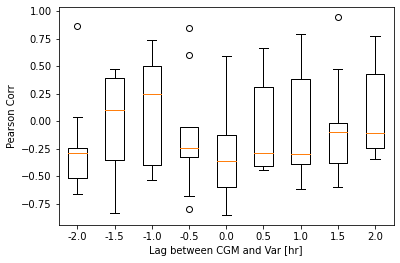

In [21]:
windowDuration=2
lagTimes=np.arange(-2,2.5,0.5)
mealTimes=[12.33,12.33,12.33,12.16,11.92,12.5,12.16,11.33,12.25]
plotFlag=False
plotParamter='Temp'

pearsonRatios=[]
days=dfInterp['Date']
days=days.values.tolist()
days=set(days)
days=list(days)
days.sort()
pearsonRatios=np.zeros((len(lagTimes),len(days)))
for i,lagTime in enumerate(lagTimes):
    for counter,day in enumerate(days):
        mealTime=mealTimes[counter]
        queryCGM=dfInterp[dfInterp['Date']==day]
        queryCGM['Time']=queryCGM['Time']/3600
        queryCGM=queryCGM[queryCGM['Parameter']=='CGM']
        queryCGM=queryCGM[queryCGM['Time']<=(mealTime+windowDuration)]
        queryCGM=queryCGM[queryCGM['Time']>=mealTime]

        queryVar=dfInterp[dfInterp['Date']==day]
        queryVar['Time']=queryVar['Time']/3600
        queryVar=queryVar[queryVar['Parameter']==plotParamter]
        queryVar=queryVar[queryVar['Time']<=(mealTime+windowDuration+lagTime)]
        queryVar=queryVar[queryVar['Time']>=(mealTime+lagTime)]
        if plotFlag:
            fig, ax1 = plt.subplots ()
            ax2 = ax1.twinx ()

            queryCGM.plot(ax=ax1,x='Time',y='Value',color='green')
            ax1.tick_params (axis='y', labelcolor='green')

            queryVar.plot(ax=ax2,x='Time',y='Value',color='red')
            ax2.tick_params (axis='y', labelcolor='red')

            ax1.set_ylabel('CGM')
            ax1.set_xlabel('Day')
            ax1.yaxis.label.set_color("green")

            ax2.set_ylabel(plotParamter)
            ax2.yaxis.label.set_color("red")

            # plt.savefig(addressPrefix+'figure'+str(day)+'.jpg')
            plt.title("Day="+str(day))
            ax1.get_legend().remove()
            ax2.get_legend().remove()
            plt.show()
        CGMData=queryCGM['Value'].values.tolist()
        CGMData=np.asarray(CGMData)
        varData=queryVar['Value'].values.tolist()
        varData=np.asarray(varData)
        discardIndex=np.argwhere(np.isnan(varData))
        varData=np.delete(varData,discardIndex)
        CGMData=np.delete(CGMData,discardIndex)
        corr, pval = pearsonr(CGMData,varData)
        # pearsonRatios.append([lagTime,day,np.round(corr,3)])
        pearsonRatios[i,counter]=np.round(corr,3)

for i,lagTime in enumerate(lagTimes):
    print("Lag time=",lagTime,"Mean pearson=",np.round(np.mean(pearsonRatios[i,:]),3))
    print(pearsonRatios[i,:])
    print("----------------------")
plt.boxplot(pearsonRatios)
plt.xticks(np.arange(1,len(lagTimes)+1), lagTimes)
plt.ylabel('Pearson Corr')
plt.xlabel('Lag between CGM and Var [hr]')
plt.show()